# Trade Under Pressure



## Import packages

In [1061]:
import functools as ft

import numpy as np
import pandas as pa
import seaborn as sns

In [1062]:
# Excluded country codes
excluded_country_codes = [
  "NCL", "ZAR", "WLF", "NFK", "PAL", "MNP", "SHN", "COK",
  "BMU", "PYF", "NIU", "ANT", "VGB", "TMP", "GUF", "CYM",
  "TCA", "REU", "FLK", "GLP", "TKL", "MTQ", "AIA", "SPM",
  "SSD", "MNT", "DDR", "BYS", "MNE", "TLS", "LIE", "VAT",
  "CSK", "MSR", "PSE", "DHY", "KOS", "KSV", "RHO", "HVO",
  "VDR", "MCO", "SVU", "XKX", "ASM", "VIR", "SXM", "CUW",
  "MAF", "GUM", "IMN", "MAC", "PCN", "ALI", "YDR", "ATA",
  "CXR", "MID", "SJM", "SPE", "UMI", "SIK", "BAT", "GAZ",
  "BUN", "SGS", "ETF", "PCZ", "TAN", "JTN", "RYU", "PCE",
  "CCK", "BVT", "USP", "KN1", "ATF", "ZPM", "IOT", "MYT",
  "HMD", "SWK", "WAK", "SVR", "ZW1", "PMY", "FRE", "BLX",
  "UNS", "SBH", "NZE", "COG"
]

replace_country_codes = {
  "ROM": {
    "values": ["ROU"]
  },
  "SER": {
    "values": ["SRB"]
  },
  "CHL": {
    "values": ["CHI"]
  },
}

## Data preprocessing
### Dist CEPII

In [1063]:
# Loading and preprocessing Dist CEPII dataset
dist_cepii = pa.read_excel("./data/geographic/dist_cepii.xls",
                           index_col=None, header=0,
                           na_values=[".", "nan", "NaN"], verbose=True, decimal=",",
                           dtype={ "contig": bool, "comlang_off": bool,
                                   "comlang_ethno": bool, "colony": bool,
                                   "smctry": bool }
                           )
dist_cepii = dist_cepii.drop(["comcol", "curcol", "col45"], axis=1)
dist_cepii = dist_cepii.rename(columns={ "iso_o": "origin", "iso_d": "destination" })

Reading sheet 0


Inspect DataFrame properties

In [1064]:
dist_cepii.head(n=50)

,origin,destination,contig,comlang_off,comlang_ethno,colony,smctry,dist,distcap,distw,distwces
0,ABW,ABW,False,False,False,False,False,5.225315,5.225315,25.09354,23.04723
1,ABW,AFG,False,False,False,False,False,13257.810000,13257.810000,13168.22000,13166.37000
2,ABW,AGO,False,False,False,False,False,9516.913000,9516.913000,9587.31600,9584.19300
3,ABW,AIA,False,False,True,False,False,983.268200,983.268200,976.89740,976.89160
4,ABW,ALB,False,False,False,False,False,9091.742000,9091.742000,9091.57600,9091.46600
5,ABW,AND,False,True,False,False,False,7572.788000,7572.788000,7570.08400,7570.08300
6,ABW,ANT,False,True,True,False,True,136.384800,136.384800,239.90640,142.85830
7,ABW,ARE,False,False,False,False,False,12735.010000,12735.010000,12773.08000,12772.95000
8,ABW,ARG,False,True,False,False,False,5396.220000,5396.220000,5187.78800,5157.12600
9,ABW,ARM,False,False,False,False,False,11107.780000,11107.780000,11106.96000,11106.76000


In [1066]:
dist_cepii.dtypes

origin            object
destination       object
contig              bool
comlang_off         bool
comlang_ethno       bool
colony              bool
smctry              bool
dist             float64
distcap          float64
distw            float64
distwces         float64
dtype: object

Check how many rows have NaN

In [1067]:
dist_cepii.isna().sum()

origin              0
destination         0
contig              0
comlang_off         0
comlang_ethno       0
colony              0
smctry              0
dist                0
distcap             0
distw            2215
distwces         2215
dtype: int64

Count how many times a country has NaN in Origin and in Destination

In [1068]:
na_rows = dist_cepii[dist_cepii.isna().any(axis=1)][["origin", "destination"]]
# Sanity check
na_rows.isna().sum()

origin         0
destination    0
dtype: int64

In [1069]:
na_rows[["origin"]].value_counts()

origin
PCN       224
CCK       224
MAC       224
MSR       224
CXR       224
         ... 
GNQ         5
GRC         5
GRD         5
GRL         5
ZWE         5
Name: count, Length: 224, dtype: int64

Check how much % of rows are NaN from the total amount

In [1070]:
print("Percentage of NaN rows: ", (na_rows.shape[0] / dist_cepii.shape[0]) * 100, "%")

Percentage of NaN rows:  4.414461096938775 %


Drop NaN values

In [1071]:
dist_cepii = dist_cepii.dropna()

In [1072]:
# Sanity check
dist_cepii.isna().any()

origin           False
destination      False
contig           False
comlang_off      False
comlang_ethno    False
colony           False
smctry           False
dist             False
distcap          False
distw            False
distwces         False
dtype: bool

Check how many unique countries there are in both origin and destination. Numbers should match.

In [1073]:
print("Unique countries in origin column", dist_cepii["origin"].nunique())
print("Unique countries in destination column", dist_cepii["destination"].nunique())

Unique countries in origin column 219
Unique countries in destination column 219


Remove unwanted countries

### GSDB V4 Dyadic

Inspect the `GSDB_V4_Dyadic.dta` - this should be a Stata file. What is the difference to `GSDB_V4.csv`?

In [1074]:
gsdb_stata = pa.read_stata("data/sanctions/GSDB_V4_Dyadic.dta")
gsdb_csv = pa.read_csv("data/sanctions/GSDB_V4.csv")

In [1075]:
# Remove sanctions against terrorist organisations
gsdb_stata = gsdb_stata[gsdb_stata["sanctioned_state_iso3"].astype(str) != '']

Retrieve rows that include `case_id` **471**:

In [1076]:
gsdb_stata[gsdb_stata["case_id"].astype(str).str.contains("471")]

,case_id,sanctioning_state_iso3,sanctioning_state,sanctioned_state_iso3,sanctioned_state,year,arms,military,trade,descr_trade,financial,travel,other,target_mult,sender_mult,objective,success
0,471,AFG,Afghanistan,AGO,Angola,1993-01-01,1,1,1,exp_part,0,0,0,0,1,end_war,success_total
1,471,AFG,Afghanistan,AGO,Angola,1994-01-01,1,1,1,exp_part,0,0,0,0,1,end_war,success_total
2,471,AFG,Afghanistan,AGO,Angola,1995-01-01,1,1,1,exp_part,0,0,0,0,1,end_war,success_total
3,471,AFG,Afghanistan,AGO,Angola,1996-01-01,1,1,1,exp_part,0,0,0,0,1,end_war,success_total
4,"471,574",AFG,Afghanistan,AGO,Angola,1997-01-01,1,1,1,exp_part,0,1,1,0,1,"end_war,end_war","success_total,success_total"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158537,"595,574,471",ZWE,Zimbabwe,AGO,Angola,1998-01-01,1,1,1,"exp_part,imp_part",1,1,1,0,1,"end_war,end_war,end_war","success_total,success_total,success_total"
158538,"574,595,471",ZWE,Zimbabwe,AGO,Angola,1999-01-01,1,1,1,"exp_part,imp_part",1,1,1,0,1,"end_war,end_war,end_war","success_total,success_total,success_total"
158539,"595,471,574",ZWE,Zimbabwe,AGO,Angola,2000-01-01,1,1,1,"exp_part,imp_part",1,1,1,0,1,"end_war,end_war,end_war","success_total,success_total,success_total"
158540,"471,595,574",ZWE,Zimbabwe,AGO,Angola,2001-01-01,1,1,1,"exp_part,imp_part",1,1,1,0,1,"end_war,end_war,end_war","success_total,success_total,success_total"


In [1077]:
gsdb_stata.head(500)

,case_id,sanctioning_state_iso3,sanctioning_state,sanctioned_state_iso3,sanctioned_state,year,arms,military,trade,descr_trade,financial,travel,other,target_mult,sender_mult,objective,success
0,471,AFG,Afghanistan,AGO,Angola,1993-01-01,1,1,1,exp_part,0,0,0,0,1,end_war,success_total
1,471,AFG,Afghanistan,AGO,Angola,1994-01-01,1,1,1,exp_part,0,0,0,0,1,end_war,success_total
2,471,AFG,Afghanistan,AGO,Angola,1995-01-01,1,1,1,exp_part,0,0,0,0,1,end_war,success_total
3,471,AFG,Afghanistan,AGO,Angola,1996-01-01,1,1,1,exp_part,0,0,0,0,1,end_war,success_total
4,"471,574",AFG,Afghanistan,AGO,Angola,1997-01-01,1,1,1,exp_part,0,1,1,0,1,"end_war,end_war","success_total,success_total"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,"300,217,321",AFG,Afghanistan,ZAF,South Africa,1987-01-01,1,1,1,exp_part,0,0,0,0,1,"policy_change,prevent_war,policy_change,preven...","success_total,success_total,success_total,succ..."
496,"321,300,217",AFG,Afghanistan,ZAF,South Africa,1988-01-01,1,1,1,exp_part,0,0,0,0,1,"policy_change,democracy,human_rights,policy_ch...","success_total,success_total,success_total,succ..."
497,"300,321,217",AFG,Afghanistan,ZAF,South Africa,1989-01-01,1,1,1,exp_part,0,0,0,0,1,"policy_change,prevent_war,policy_change,democr...","success_total,success_total,success_total,succ..."
498,"300,321,217",AFG,Afghanistan,ZAF,South Africa,1990-01-01,1,1,1,exp_part,0,0,0,0,1,"policy_change,prevent_war,policy_change,democr...","success_total,success_total,success_total,succ..."


In [1078]:
gsdb_csv.head(500)

,case_id,sanctioned_state,sanctioning_state,begin,end,trade,descr_trade,arms,military,financial,travel,other,target_mult,sender_mult,objective,success
0,1,German Democratic Republic,Germany,1949,1973,0,NaN,0,0,0,0,1,0,0,territorial_conflict,success_total
1,2,Pakistan,India,1949,1951,1,"exp_compl,imp_compl",0,0,0,0,0,0,0,policy_change,nego_settlement
2,3,Bulgaria,United States,1950,1963,0,NaN,0,0,1,0,0,0,0,destab_regime,success_part
3,4,Bulgaria,United States,1950,1966,0,NaN,0,0,0,0,1,0,0,destab_regime,failed
4,5,Bulgaria,United States,1950,1959,0,NaN,0,0,0,1,0,0,0,destab_regime,success_part
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Russia,Ukraine,1993,1996,1,imp_part,0,1,0,0,0,0,0,policy_change,nego_settlement
496,497,Sudan,United States,1993,2020,0,NaN,0,0,1,0,0,0,0,terrorism,success_part
497,498,Togo,EU,1993,2007,0,NaN,0,0,1,0,0,0,1,"democracy,human_rights","success_total,success_total"
498,499,Togo,France,1993,2008,0,NaN,0,0,1,0,0,0,0,"human_rights,democracy,end_war","success_total,success_total,success_total"


In [1079]:
print("Shape for Stata data: ", gsdb_stata.shape)
print("Shape for XLS data:", gsdb_csv.shape)

Shape for Stata data:  (150200, 17)
Shape for XLS data: (1547, 16)


In [1080]:
# Column names Stata
gsdb_stata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150200 entries, 0 to 159064
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   case_id                 150200 non-null  object        
 1   sanctioning_state_iso3  150200 non-null  object        
 2   sanctioning_state       150200 non-null  object        
 3   sanctioned_state_iso3   150200 non-null  object        
 4   sanctioned_state        150200 non-null  object        
 5   year                    150200 non-null  datetime64[ns]
 6   arms                    150200 non-null  int8          
 7   military                150200 non-null  int8          
 8   trade                   150200 non-null  int8          
 9   descr_trade             150200 non-null  object        
 10  financial               150200 non-null  int8          
 11  travel                  150200 non-null  int8          
 12  other                   150200 non-

In [1081]:
gsdb_stata.dtypes

case_id                           object
sanctioning_state_iso3            object
sanctioning_state                 object
sanctioned_state_iso3             object
sanctioned_state                  object
year                      datetime64[ns]
arms                                int8
military                            int8
trade                               int8
descr_trade                       object
financial                           int8
travel                              int8
other                               int8
target_mult                         int8
sender_mult                         int8
objective                         object
success                           object
dtype: object

In [1082]:
# Column names XLS
gsdb_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   case_id            1547 non-null   int64 
 1   sanctioned_state   1547 non-null   object
 2   sanctioning_state  1547 non-null   object
 3   begin              1547 non-null   int64 
 4   end                1547 non-null   int64 
 5   trade              1547 non-null   int64 
 6   descr_trade        588 non-null    object
 7   arms               1547 non-null   int64 
 8   military           1547 non-null   int64 
 9   financial          1547 non-null   int64 
 10  travel             1547 non-null   int64 
 11  other              1547 non-null   int64 
 12  target_mult        1547 non-null   int64 
 13  sender_mult        1547 non-null   int64 
 14  objective          1547 non-null   object
 15  success            1547 non-null   object
dtypes: int64(11), object(5)
memory usage: 193.

In [1083]:
gsdb_csv.dtypes

case_id               int64
sanctioned_state     object
sanctioning_state    object
begin                 int64
end                   int64
trade                 int64
descr_trade          object
arms                  int64
military              int64
financial             int64
travel                int64
other                 int64
target_mult           int64
sender_mult           int64
objective            object
success              object
dtype: object

In [1084]:
gsdb_stata.isna().any()

case_id                   False
sanctioning_state_iso3    False
sanctioning_state         False
sanctioned_state_iso3     False
sanctioned_state          False
year                      False
arms                      False
military                  False
trade                     False
descr_trade               False
financial                 False
travel                    False
other                     False
target_mult               False
sender_mult               False
objective                 False
success                   False
dtype: bool

In [1085]:
(gsdb_stata["sanctioned_state_iso3"].astype(str) == '').sum()

np.int64(0)

In [1086]:
gsdb_stata[gsdb_stata["sanctioning_state_iso3"] == "YUG"]

,case_id,sanctioning_state_iso3,sanctioning_state,sanctioned_state_iso3,sanctioned_state,year,arms,military,trade,descr_trade,financial,travel,other,target_mult,sender_mult,objective,success
157697,420,YUG,Yugoslavia,BIH,Bosnia and Herzegovina,1991-01-01,1,0,0,,0,0,0,1,1,end_war,success_total
157698,22,YUG,Yugoslavia,CHN,China,1951-01-01,1,0,0,,0,0,0,0,1,"end_war,destab_regime","success_total,failed"
157699,22,YUG,Yugoslavia,CHN,China,1952-01-01,1,0,0,,0,0,0,0,1,"end_war,destab_regime","success_total,failed"
157700,22,YUG,Yugoslavia,CHN,China,1953-01-01,1,0,0,,0,0,0,0,1,"end_war,destab_regime","success_total,failed"
157701,420,YUG,Yugoslavia,HRV,Croatia,1991-01-01,1,0,0,,0,0,0,1,1,end_war,success_total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157820,"300,217,321",YUG,Yugoslavia,ZAF,South Africa,1987-01-01,1,1,1,exp_part,0,0,0,0,1,"policy_change,prevent_war,policy_change,preven...","success_total,success_total,success_total,succ..."
157821,"300,217,321",YUG,Yugoslavia,ZAF,South Africa,1988-01-01,1,1,1,exp_part,0,0,0,0,1,"policy_change,prevent_war,policy_change,preven...","success_total,success_total,success_total,succ..."
157822,"300,217,321",YUG,Yugoslavia,ZAF,South Africa,1989-01-01,1,1,1,exp_part,0,0,0,0,1,"policy_change,prevent_war,policy_change,preven...","success_total,success_total,success_total,succ..."
157823,"300,217,321",YUG,Yugoslavia,ZAF,South Africa,1990-01-01,1,1,1,exp_part,0,0,0,0,1,"policy_change,prevent_war,policy_change,preven...","success_total,success_total,success_total,succ..."


Try to unify names

### GDP Data

In [1087]:
gdp = pa.read_csv(filepath_or_buffer="data/economic/GDP(currentUSD)_1974-2023.csv", sep=",", na_values=["..", "nan"])

In [1088]:
gdp = gdp.drop(["Series Name", "Series Code", "Country Name"], axis=1)

In [1089]:
gdp = gdp.rename(columns=lambda x: x if not x.endswith("]") else x.split(" ")[0])
gdp = gdp.rename(columns={ "Country Code": "ISO3" })

In [1090]:
gdp.head(10)

,ISO3,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.049713e+10,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426000e+10,1.449724e+10,1.723305e+10
1,ALB,NaN,NaN,NaN,NaN,NaN,NaN,1.578102e+09,1.808177e+09,1.861163e+09,...,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.537951e+10,1.558511e+10,1.524146e+10,1.803201e+10,1.901724e+10,2.354718e+10
2,DZA,1.320987e+10,1.555790e+10,1.772824e+10,2.097211e+10,2.636449e+10,3.324371e+10,4.234583e+10,4.434859e+10,4.520717e+10,...,2.389427e+11,1.874939e+11,1.807638e+11,1.898809e+11,1.945545e+11,1.934597e+11,1.648734e+11,1.862312e+11,2.256385e+11,2.476262e+11
3,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.430000e+08,6.730000e+08,6.710000e+08,6.120000e+08,6.390000e+08,6.470000e+08,7.210000e+08,7.500000e+08,8.710000e+08,NaN
4,AND,1.865571e+08,2.201126e+08,2.272839e+08,2.539979e+08,3.080203e+08,4.115487e+08,4.463778e+08,3.889833e+08,3.759147e+08,...,3.271686e+09,2.789881e+09,2.896610e+09,3.000162e+09,3.218420e+09,3.155149e+09,2.891001e+09,3.324648e+09,3.380613e+09,3.785067e+09
5,AGO,NaN,NaN,NaN,NaN,NaN,NaN,5.930503e+09,5.550483e+09,5.550483e+09,...,1.359668e+11,9.049642e+10,5.276162e+10,7.369015e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,8.482465e+10
6,ATG,NaN,NaN,NaN,7.749630e+07,8.803333e+07,1.095852e+08,1.324407e+08,1.493778e+08,1.664259e+08,...,1.378830e+09,1.437756e+09,1.489693e+09,1.531152e+09,1.661530e+09,1.725352e+09,1.410796e+09,1.601367e+09,1.867733e+09,2.033085e+09
7,ARG,7.243678e+10,5.243865e+10,5.116950e+10,5.678100e+10,8.904945e+10,6.925233e+10,7.696192e+10,7.867684e+10,8.430749e+10,...,5.263197e+11,5.947493e+11,5.575323e+11,6.436284e+11,5.248199e+11,4.477547e+11,3.857405e+11,4.865641e+11,6.327901e+11,6.460753e+11
8,ARM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.160951e+10,1.055334e+10,1.054614e+10,1.152746e+10,1.245794e+10,1.361929e+10,1.264170e+10,1.387891e+10,1.951351e+10,2.408575e+10
9,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.790850e+09,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.481857e+09,2.929447e+09,3.279344e+09,3.648573e+09


In [1091]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ISO3    217 non-null    object 
 1   1974    147 non-null    float64
 2   1975    150 non-null    float64
 3   1976    150 non-null    float64
 4   1977    153 non-null    float64
 5   1978    152 non-null    float64
 6   1979    153 non-null    float64
 7   1980    163 non-null    float64
 8   1981    163 non-null    float64
 9   1982    164 non-null    float64
 10  1983    164 non-null    float64
 11  1984    166 non-null    float64
 12  1985    168 non-null    float64
 13  1986    168 non-null    float64
 14  1987    174 non-null    float64
 15  1988    176 non-null    float64
 16  1989    176 non-null    float64
 17  1990    192 non-null    float64
 18  1991    193 non-null    float64
 19  1992    194 non-null    float64
 20  1993    195 non-null    float64
 21  1994    196 non-null    float64
 22  19

In [1092]:
gdp.shape

(222, 51)

Check how many countries there are in the dataset.

In [1093]:
gdp["ISO3"].nunique()

217

In [1094]:
gdp["ISO3"].isna().sum()

np.int64(5)

In [1095]:
gdp = gdp[~gdp["ISO3"].isna()]
print("Shape after removing NaN: ", gdp.shape)

Shape after removing NaN:  (217, 51)


Check countries that are in CEPII, but not in GDP dataset.

In [1096]:
countries_unique_to_cepii = list(set(dist_cepii["origin"].unique()) - set(gdp["ISO3"].unique()))
countries_unique_to_cepii

['SHN',
 'YUG',
 'SPM',
 'ROM',
 'TWN',
 'REU',
 'PAL',
 'ESH',
 'FLK',
 'COK',
 'TMP',
 'NIU',
 'AIA',
 'ZAR',
 'ANT',
 'GLP',
 'WLF',
 'NFK',
 'MTQ',
 'GUF',
 'TKL']

Check countries that are in GDP, but not in CEPII dataset.

In [1097]:
countries_unique_to_gdp = list(set(gdp["ISO3"].unique()) - set(dist_cepii["origin"].unique()))
countries_unique_to_gdp

['MAC',
 'TLS',
 'SSD',
 'VIR',
 'CHI',
 'ROU',
 'PSE',
 'GUM',
 'MCO',
 'CUW',
 'LIE',
 'SRB',
 'MNE',
 'COD',
 'IMN',
 'SXM',
 'MAF',
 'ASM',
 'XKX']

### UN Comtrade

In [1098]:
import pandas as pd
import os

# Specify the input and output file paths
input_file = "data/trade/Romania_2020_Plus"  # Update with your input file's path
output_file = "data/trade/Romania_2020_Plus.xlsx"  # Desired output Excel file path

# Determine the file extension to decide how to read the input file
_, ext = os.path.splitext(input_file)
ext = ext.lower()

df = None  # Initialize df


def convert(active):
  if active:
    return
  try:
    if ext in ['.csv', '']:
      # Assume the file is tab-delimited (TSV)
      df = pd.read_csv(input_file, sep='\t', low_memory=False)
    elif ext in ['.xls', '.xlsx']:
      df = pd.read_excel(input_file)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")
    print("File read successfully!")
  except Exception as e:
    print(f"Error reading the input file: {e}")

  # Only attempt conversion if the DataFrame was successfully created
  if df is not None:
    try:
      df.to_excel(output_file, index=False)
      print(f"Conversion successful! The Excel file is saved as: {output_file}")
    except Exception as e:
      print(f"Error writing to Excel: {e}")
  else:
    print("Skipping conversion to Excel because the input file could not be read.")


# Read the input file into a DataFrame
convert(True)


### Rename and remove countries

In [1099]:
gdp = gdp[~gdp.isin(["CHI"]).any(axis=1)]
for key in replace_country_codes.keys():
  for value in replace_country_codes[key]["values"]:
    dist_cepii = dist_cepii.replace(value, key)
    gdp = gdp.replace(value, key)
    gsdb_stata = gsdb_stata.replace(value, key)
    print("Replacing", value, "with", key)

Replacing ROU with ROM
Replacing SRB with SER
Replacing CHI with CHL


In [1100]:

dist_cepii = dist_cepii[~dist_cepii.isin(excluded_country_codes).any(axis=1)]
gsdb_stata = gsdb_stata[~gsdb_stata.isin(excluded_country_codes).any(axis=1)]
gdp = gdp[~gdp.isin(excluded_country_codes).any(axis=1)]

In [1101]:

# Set distance for SER to the distance of YUG
yug_rows = dist_cepii[dist_cepii.apply(lambda row: row.astype(str).str.contains("YUG").any(), axis=1)].copy()
yug_rows = yug_rows.replace("YUG", "SER")
dist_cepii = pd.concat([dist_cepii, yug_rows], ignore_index=True)



## Collect and analyze country labels in all the data sets

### Country codes

In [1102]:
country_codes = pa.read_excel("./data/geographic/country_codes.xls",
                              dtype={
                                "CountryCode": object,
                              })
country_codes = country_codes[~country_codes.isin(excluded_country_codes).any(axis=1)]

In [1103]:
country_codes = country_codes.rename(columns={ "CountryCode": "UNDS" })

In [1104]:
country_codes.shape

(197, 3)

In [1105]:
# Check if all unique
print("All Unique ?: ", country_codes.shape[0] == len(country_codes["ISO3"].unique()))

All Unique ?:  True


In [1106]:
country_codes_labels = country_codes["ISO3"]

In [1107]:
np.array(country_codes_labels)

array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG',
       'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR',
       'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN',
       'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP',
       'EST', 'ETH', 'EUN', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB',
       'GBR', 'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC',
       'GRD', 'GRL', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN',
       'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR',
       'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU',
       'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD',
       'MLI', 'MLT', 'MMR', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS',
       'NAM', 'NER',

### DIST CEPII Labels

In [1108]:
dist_labels_origin = dist_cepii["origin"].unique()
print(len(dist_labels_origin))
dist_labels_origin

195


array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG',
       'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR',
       'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN',
       'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP',
       'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR',
       'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD',
       'GRL', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN',
       'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR',
       'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT',
       'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX',
       'LVA', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI',
       'MLT', 'MMR', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM',
       'NER', 'NGA',

In [1109]:
dist_cepii["origin"].unique()
dist_cepii["origin"].isna().sum()

np.int64(0)

In [1110]:
dist_labels_dest = dist_cepii["destination"].unique()
print(len(dist_labels_dest))
dist_labels_dest

195


array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG',
       'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR',
       'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN',
       'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP',
       'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR',
       'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD',
       'GRL', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN',
       'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR',
       'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT',
       'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX',
       'LVA', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI',
       'MLT', 'MMR', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM',
       'NER', 'NGA',

In [1111]:
dist_cepii["destination"]

0        ABW
1        AFG
2        AGO
3        ALB
4        AND
        ... 
38018    ZMB
38019    ZWE
38020    SER
38021    SER
38022    SER
Name: destination, Length: 38023, dtype: object

In [1112]:
# Check if there are any differences
dist_labels_check = np.array(dist_labels_origin == dist_labels_dest)
print("Any false:", np.any(~dist_labels_check))

Any false: False


In [1113]:
# Sanity check
print("Sum of TRUE values: ", sum(dist_labels_check))
print("Lenght of ALL values: ", len(dist_labels_check))

Sum of TRUE values:  195
Lenght of ALL values:  195


In [1114]:
dist_labels = dist_labels_origin

In [1115]:
len(dist_labels)

195

In [1116]:
len(np.unique(dist_labels))

195

### GSDB Labels

In [1117]:
gsdb_sanctioning_labels = gsdb_stata["sanctioning_state_iso3"].unique()
gsdb_sanctioned_labels = gsdb_stata["sanctioned_state_iso3"].unique()

In [1118]:
print("Number of unique sanctioning: ", len(gsdb_sanctioning_labels))
print("Number of unique sanctioned: ", len(gsdb_sanctioned_labels))

Number of unique sanctioning:  191
Number of unique sanctioned:  176


In [1119]:
unique_to_sanctioning = list(set(gsdb_sanctioning_labels) - set(gsdb_sanctioned_labels))
print("Unique to SANCTIONING:", unique_to_sanctioning)

unique_to_sanctioned = list(set(gsdb_sanctioned_labels) - set(gsdb_sanctioning_labels))
print("Unique to SANCTIONED: ", unique_to_sanctioned)

Unique to SANCTIONING: ['ESH', 'TON', 'BRN', 'SWZ', 'VUT', 'BHS', 'SLB', 'PLW', 'BTN', 'VCT', 'STP', 'TUV', 'KNA', 'PNG', 'KIR', 'FSM']
Unique to SANCTIONED:  ['GIB']


In [1120]:
gsdb_labels = np.union1d(gsdb_sanctioned_labels, gsdb_sanctioning_labels)
print("Total numbers of GSDB labels: ", len(gsdb_labels))

Total numbers of GSDB labels:  192


### GDP Labels

In [1121]:
gdp_labels = gdp["ISO3"].unique()
gdp_labels

array(['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG', 'ARM', 'ABW',
       'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL',
       'BLZ', 'BEN', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'BRN', 'BGR',
       'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CAF', 'TCD', 'CHL',
       'CHN', 'COL', 'COM', 'COD', 'CRI', 'CIV', 'HRV', 'CUB', 'CYP',
       'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ',
       'ERI', 'EST', 'SWZ', 'ETH', 'FRO', 'FJI', 'FIN', 'FRA', 'GAB',
       'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GTM',
       'GIN', 'GNB', 'GUY', 'HTI', 'HND', 'HKG', 'HUN', 'ISL', 'IND',
       'IDN', 'IRN', 'IRQ', 'IRL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR',
       'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA',
       'LBN', 'LSO', 'LBR', 'LBY', 'LTU', 'LUX', 'MDG', 'MWI', 'MYS',
       'MDV', 'MLI', 'MLT', 'MHL', 'MRT', 'MUS', 'MEX', 'FSM', 'MDA',
       'MNG', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NZL',
       'NIC', 'NER',

### Matching

In [1122]:
print("Number of DIST CEPII labels: ", len(dist_labels))
print("Number of GSDB labels: ", len(gsdb_labels))
print("Number of GDP labels: ", len(gdp_labels))
print("Number of country codes: ", len(country_codes_labels))

label_arrays = [dist_labels, gsdb_labels, gdp_labels, country_codes_labels]

intersection_labels = ft.reduce(np.intersect1d, label_arrays)

print("Total number of intersect labels: ", len(intersection_labels))

Number of DIST CEPII labels:  195
Number of GSDB labels:  192
Number of GDP labels:  193
Number of country codes:  197
Total number of intersect labels:  188


In [1123]:
intersection_labels

array(['AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS',
       'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR',
       'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN',
       'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COL',
       'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA',
       'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FRA', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB',
       'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GTM', 'GUY', 'HKG',
       'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ',
       'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ',
       'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY',
       'LCA', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MDG',
       'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT', 'MMR', 'MNG', 'MOZ',
       'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD',
       'NOR', 'NPL',

In [1124]:
# Intersection of each set with each other
inter_dist_gsdb = np.intersect1d(gsdb_labels, dist_labels)
print("Intersect DIST CEPII and GSDB labels: ", len(inter_dist_gsdb))
list(set(gsdb_labels) - set(inter_dist_gsdb))

Intersect DIST CEPII and GSDB labels:  191


['COD']

In [1125]:
list(set(dist_labels) - set(intersection_labels))

['ESH', 'YUG', 'GRL', 'PRI', 'FRO', 'TWN', 'ABW']

In [1126]:
list(set(gsdb_labels) - set(intersection_labels))

['ESH', 'TWN', 'COD', 'YUG']

In [1127]:
list(set(gdp_labels) - set(intersection_labels))

['COD', 'GRL', 'PRI', 'FRO', 'ABW']

In [1128]:
list(set(country_codes_labels) - set(intersection_labels))

['WLD', 'ESH', 'YUG', 'EUN', 'GRL', 'PRI', 'FRO', 'TWN', 'ABW']

In [1129]:
############
############
############

## Combine Data Sets
Merge the existing data sets into combined data sets for data exploration

In [1130]:
# First combine country codes and GDP
country_codes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 274
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ISO3          197 non-null    object
 1   UNDS          197 non-null    object
 2   Country Name  197 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


In [1131]:
country_codes.shape

(197, 3)

In [1132]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 0 to 216
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ISO3    193 non-null    object 
 1   1974    141 non-null    float64
 2   1975    144 non-null    float64
 3   1976    144 non-null    float64
 4   1977    147 non-null    float64
 5   1978    146 non-null    float64
 6   1979    147 non-null    float64
 7   1980    157 non-null    float64
 8   1981    157 non-null    float64
 9   1982    157 non-null    float64
 10  1983    157 non-null    float64
 11  1984    158 non-null    float64
 12  1985    160 non-null    float64
 13  1986    160 non-null    float64
 14  1987    166 non-null    float64
 15  1988    168 non-null    float64
 16  1989    168 non-null    float64
 17  1990    183 non-null    float64
 18  1991    184 non-null    float64
 19  1992    185 non-null    float64
 20  1993    186 non-null    float64
 21  1994    186 non-null    float64
 22  1995   

In [1133]:
gdp.shape

(193, 51)

In [1134]:
# Inner join GDP and Country Names
gdp_countries = pa.merge(
  gdp[gdp["ISO3"].isin(intersection_labels)],
  country_codes[country_codes["ISO3"].isin(intersection_labels)]
  , on="ISO3", how="inner", validate="m:m")
gdp_countries.info()
list(set(gdp_countries["ISO3"]) - set(intersection_labels))
len(intersection_labels)
len(gdp_countries["ISO3"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 53 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ISO3          188 non-null    object 
 1   1974          137 non-null    float64
 2   1975          140 non-null    float64
 3   1976          140 non-null    float64
 4   1977          143 non-null    float64
 5   1978          142 non-null    float64
 6   1979          143 non-null    float64
 7   1980          153 non-null    float64
 8   1981          153 non-null    float64
 9   1982          153 non-null    float64
 10  1983          153 non-null    float64
 11  1984          154 non-null    float64
 12  1985          156 non-null    float64
 13  1986          155 non-null    float64
 14  1987          161 non-null    float64
 15  1988          163 non-null    float64
 16  1989          163 non-null    float64
 17  1990          178 non-null    float64
 18  1991          179 non-null    

188

In [1135]:
gdp_countries.shape

(188, 53)

In [1136]:
gdp_countries

,ISO3,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2016,2017,2018,2019,2020,2021,2022,2023,UNDS,Country Name
0,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426000e+10,1.449724e+10,1.723305e+10,004,Afghanistan
1,ALB,NaN,NaN,NaN,NaN,NaN,NaN,1.578102e+09,1.808177e+09,1.861163e+09,...,1.186120e+10,1.301973e+10,1.537951e+10,1.558511e+10,1.524146e+10,1.803201e+10,1.901724e+10,2.354718e+10,008,Albania
2,DZA,1.320987e+10,1.555790e+10,1.772824e+10,2.097211e+10,2.636449e+10,3.324371e+10,4.234583e+10,4.434859e+10,4.520717e+10,...,1.807638e+11,1.898809e+11,1.945545e+11,1.934597e+11,1.648734e+11,1.862312e+11,2.256385e+11,2.476262e+11,012,Algeria
3,AND,1.865571e+08,2.201126e+08,2.272839e+08,2.539979e+08,3.080203e+08,4.115487e+08,4.463778e+08,3.889833e+08,3.759147e+08,...,2.896610e+09,3.000162e+09,3.218420e+09,3.155149e+09,2.891001e+09,3.324648e+09,3.380613e+09,3.785067e+09,020,Andorra
4,AGO,NaN,NaN,NaN,NaN,NaN,NaN,5.930503e+09,5.550483e+09,5.550483e+09,...,5.276162e+10,7.369015e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,8.482465e+10,024,Angola
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,VEN,2.610093e+10,2.746465e+10,3.141953e+10,3.621070e+10,3.931628e+10,4.831093e+10,5.911651e+10,6.632744e+10,6.773674e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,862,Venezuela
184,VNM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.570960e+11,2.813536e+11,3.101065e+11,3.343653e+11,3.466157e+11,3.664748e+11,4.103240e+11,4.297170e+11,704,Vietnam
185,YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.131782e+10,2.684223e+10,2.160616e+10,NaN,NaN,NaN,NaN,NaN,887,Yemen
186,ZMB,2.910981e+09,2.442672e+09,2.742859e+09,2.515297e+09,2.811032e+09,3.353445e+09,3.884531e+09,4.008126e+09,3.871117e+09,...,2.095841e+10,2.587360e+10,2.631151e+10,2.330867e+10,1.813776e+10,2.209642e+10,2.916378e+10,2.757796e+10,894,Zambia


## Data Visualization

In [1247]:
sns.set_theme(style="whitegrid")

In [1255]:
gdp_subset = gdp_countries.head(100)
gdp_subset = gdp_subset.drop(["UNDS", "Country Name"], axis=1)

In [1]:
gdp_subset

NameError: name 'gdp_subset' is not defined

In [1257]:
# gdp_subset = gdp_subset.set_index("ISO3").T

In [1258]:
gdp_subset

,ISO3,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.049713e+10,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426000e+10,1.449724e+10,1.723305e+10
1,ALB,NaN,NaN,NaN,NaN,NaN,NaN,1.578102e+09,1.808177e+09,1.861163e+09,...,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.537951e+10,1.558511e+10,1.524146e+10,1.803201e+10,1.901724e+10,2.354718e+10
2,DZA,1.320987e+10,1.555790e+10,1.772824e+10,2.097211e+10,2.636449e+10,3.324371e+10,4.234583e+10,4.434859e+10,4.520717e+10,...,2.389427e+11,1.874939e+11,1.807638e+11,1.898809e+11,1.945545e+11,1.934597e+11,1.648734e+11,1.862312e+11,2.256385e+11,2.476262e+11
3,AND,1.865571e+08,2.201126e+08,2.272839e+08,2.539979e+08,3.080203e+08,4.115487e+08,4.463778e+08,3.889833e+08,3.759147e+08,...,3.271686e+09,2.789881e+09,2.896610e+09,3.000162e+09,3.218420e+09,3.155149e+09,2.891001e+09,3.324648e+09,3.380613e+09,3.785067e+09
4,AGO,NaN,NaN,NaN,NaN,NaN,NaN,5.930503e+09,5.550483e+09,5.550483e+09,...,1.359668e+11,9.049642e+10,5.276162e+10,7.369015e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,8.482465e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,LBN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.809521e+10,4.992934e+10,5.114731e+10,5.302768e+10,5.490152e+10,5.160596e+10,3.171213e+10,2.313194e+10,2.099242e+10,NaN
96,LSO,1.508513e+08,1.495589e+08,1.476600e+08,1.933150e+08,2.665701e+08,2.901346e+08,4.315425e+08,4.341880e+08,3.487417e+08,...,2.441063e+09,2.359687e+09,2.114426e+09,2.306742e+09,2.556247e+09,2.390702e+09,2.053700e+09,2.412130e+09,2.354683e+09,2.117962e+09
97,LBR,4.869550e+08,5.775493e+08,5.966757e+08,6.730106e+08,7.172404e+08,8.140679e+08,8.547115e+08,8.465145e+08,8.639332e+08,...,3.225652e+09,3.227076e+09,3.398420e+09,3.390703e+09,3.422755e+09,3.319596e+09,3.176126e+09,3.513050e+09,4.001047e+09,4.240000e+09
98,LBY,1.511254e+10,1.471091e+10,1.909694e+10,2.242830e+10,2.213642e+10,3.053643e+10,4.095392e+10,3.637435e+10,3.376015e+10,...,5.737236e+10,4.871750e+10,4.991207e+10,6.715745e+10,7.668603e+10,6.925450e+10,4.685429e+10,3.521800e+10,4.324630e+10,4.509646e+10


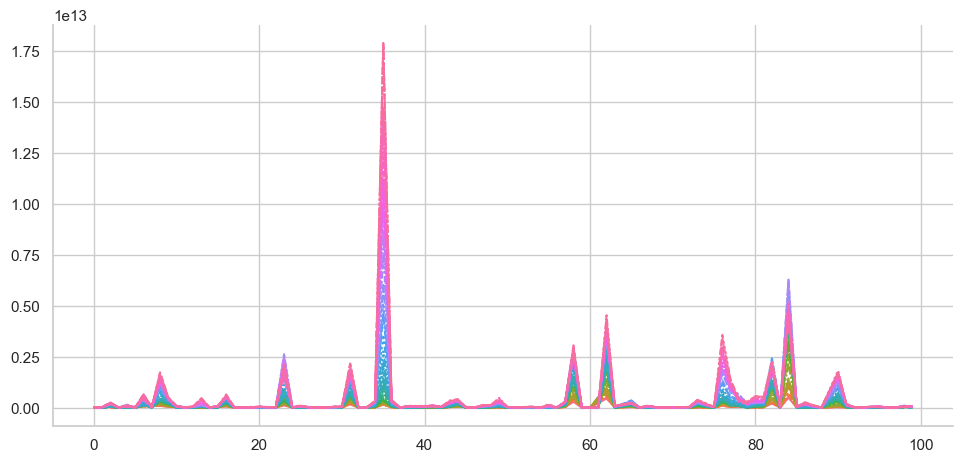

In [1259]:
plot = sns.relplot(data=gdp_subset, kind="line", legend=False, aspect=2)
xticks = range(1970, 2030, 2)
test_something = ((((((((((((()))))))))))))

In [1262]:
gdp_melt = gdp_subset.melt(id_vars=["ISO3"], var_name="Year", value_name="GDP", dropna=True, legend=False)
gdp_melt

TypeError: DataFrame.melt() got an unexpected keyword argument 'dropna'

<Axes: xlabel='GDP', ylabel='Density'>

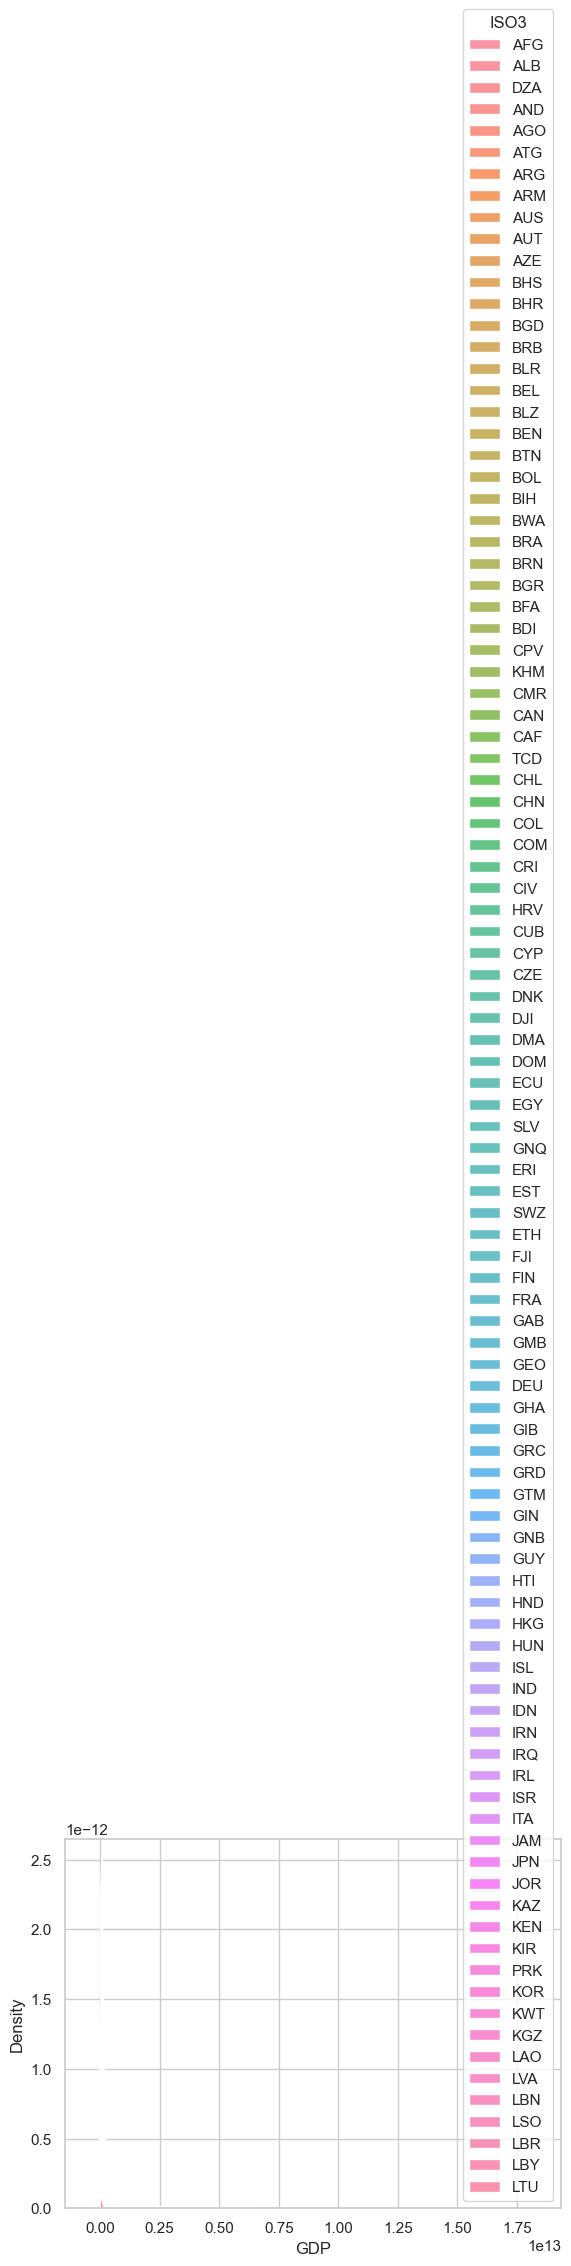

In [1261]:
sns.kdeplot(data=gdp_melt, x="GDP", hue="ISO3", multiple="stack")

---







# --- ENDE GELÄNDE ---